In [1]:
import io
import pandas as pd
df = pd.read_csv('omicron_tweets_final.csv')

In [2]:
df

,Unnamed: 0,username,description,location,date,following,followers,totaltweets,retweetcount,text,hashtags
0,0,JohnNosta,I'm a technology theorist driving innovation a...,7945,31-12-2021 23:59,51711.0,68252.0,131956.0,134.0,We got our tickets!! #NewYear2022 #COVID19 #Om...,"['NewYear2022', 'COVID19', 'Omicron']"
1,1,njoyflyfishing,Global Venture Captial and Private Equity/Busi...,"Los Angeles, CA",31-12-2021 23:58,10.0,42.0,111219.0,2.0,Growth in 7D Deaths by State 2021-12-27: Covi...,"['datavisualization', 'datascience', 'analytic..."
2,2,SarahRNeibart,Mayor of the Greatest Small Town in America @M...,NaN,31-12-2021 23:58,3248.0,904.0,4652.0,0.0,As we await for the peak of the new #Omicron v...,['Omicron']
3,3,pop_popculture,#OmicronisAirborne #BetterMasks #N95 #HEPA #Ge...,Home,31-12-2021 23:58,4998.0,857.0,80928.0,0.0,@SGaibrie What if 3 of your #rapidtests are po...,"['rapidtests', 'pcr', 'rats', 'pcr', 'pcrtest'..."
4,4,MarcGozlan,"Médecin de formation, journaliste médico-scien...","Paris, France",31-12-2021 23:58,3683.0,19714.0,37949.0,3.0,South Africa: A different pattern of character...,"['COVID19', 'Omicron']"
...,...,...,...,...,...,...,...,...,...,...,...
20481,495,CLTVoicesOfHlth,UNC Charlotte undergrads offer education on pu...,"Charlotte, NC",07-01-2022 18:03,232.0,359.0,426.0,0.0,What is your perceived anxiety level pertainin...,['OmicronVariant']
20482,496,KenCarlson16,County Government/Health reporter\r\n@modestobee,"Modesto, CA",07-01-2022 18:01,1102.0,658.0,550.0,0.0,#OmicronVariant generates exploding case numbe...,['OmicronVariant']
20483,497,BloombergQuint,#India’s premier multi-platform #business and ...,"Mumbai, India",07-01-2022 18:00,131.0,269562.0,277176.0,0.0,#HongKong’s economic outlook for this year is ...,"['HongKong', 'OmicronVariant']"
20484,498,ABurbidge,"ft gardener, creator of garden-themed greeting...","Toronto, CAN",07-01-2022 17:58,945.0,884.0,13498.0,0.0,Mississauga closes all libraries— except to pi...,"['OmicronVariant', 'TOpoli']"


In [3]:
df.shape

(20486, 11)

In [ ]:
!pip install vaderSentiment

In [98]:
!pip install flair

In [7]:
df[df.duplicated()]
df.drop_duplicates(keep=False,inplace=True)
df.shape

(19571, 11)

In [10]:
import numpy as np
import pandas as pd

!pip install matplotlib
import matplotlib.pyplot as plt

!pip install pycountry
import pycountry
import seaborn as sns
import re, string
!pip install emoji
import emoji

##sentiment analysis


#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from textblob import TextBlob
from flair.models import TextClassifier
from flair.data import Sentence
from wordcloud import WordCloud, STOPWORDS


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
df['location'].value_counts()

India                          752
Los Angeles, CA                581
New Delhi, India               279
United States                  226
Mumbai, India                  170
                              ... 
Distington Cumbria               1
Gopalgonj                        1
 France                          1
Manchester, EU again soon🇪🇺      1
With dear Dear Prudence          1
Name: location, Length: 3999, dtype: int64

In [14]:
countries_list = []
for i in list(pycountry.countries):
    countries_list.append(i.name)
countries = []
for c1 in df.location.values:
    if type(c1) != str:
        countries.append(np.nan)
    else:
        cnt=0 ##counter to check if we arrived at the end of the country list
        for c2 in countries_list:
            if c2 in c1:
                countries.append(c2)
                break
            else:
                cnt+=1
                if cnt== len(countries_list):
                    countries.append(np.nan)
df['country'] = countries

In [16]:
df['country'].value_counts().head()

India            2400
Canada            584
Australia         429
United States     246
Pakistan          223
Name: country, dtype: int64

In [17]:
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): ## remove multiple spaces
    return re.sub("\s\s+" , " ", text)

def remove_spam(text):
    match = re.search(r'subscribe', text)
    if match:
        return ''
    else:
        return text
def percentage(part,whole):
    return 100*float(part)/float(whole)
stopwords = ['omicron','u','s','t'] + list(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


In [24]:
texts= df.text

In [26]:
texts_new = []
for t in texts:
    texts_new.append(remove_spam(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(str(t))))))))
df['text_clean'] = texts_new 

In [27]:
df['text_clean'] = df['text_clean'].str.lower() 
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)
df['text_len'] = text_len
df = df[df['text_len'] > 4]

In [28]:
nltk = SentimentIntensityAnalyzer()
sentiments_nltk = []
for tweet in df.text_clean:
    sentiment_dict = nltk.polarity_scores(tweet)
    sentiment_dict.pop('compound', None)
    sentiments_nltk.append(max(sentiment_dict , key=sentiment_dict.get))
df['sentiment_nltk'] = sentiments_nltk
df['sentiment_nltk'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


neu    19166
pos       56
neg       51
Name: sentiment_nltk, dtype: int64

In [29]:
def polarity_to_text(blob):
    if (blob.sentiment.polarity > 0.1):
        return 'pos'
    elif(blob.sentiment.polarity <= 0.1 and  blob.sentiment.polarity >= -0.05):
        return 'neu'
    else:
        return 'neg'
sentiments_blob = []
for tweet in df.text_clean:
    blob = TextBlob(tweet)
    sentiments_blob.append(polarity_to_text(blob))
df['sentiment_blob'] = sentiments_blob
df['sentiment_blob'].value_counts()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


neu    8897
pos    7184
neg    3192
Name: sentiment_blob, dtype: int64

In [99]:
flair_clf = TextClassifier.load('sentiment-fast');
def emotion_threshold(emo, val):
    if (emo =='POSITIVE') & (val >= 0.7): #outputs 'pos' only if positive confidence > 70%
        return 'pos'
    elif(emo =='NEGATIVE') & (val >= 0.7): #outputs 'neg' only if negative confidence > 70%
        return 'neg'
    else:
        return 'neu' #else outputs neutral emotion
sentiments_flair = []
for tweet in df.text_clean:
    sentence = Sentence(tweet)
    flair_clf.predict(sentence)
    emo = re.findall(r"([A-Z]\w+)",str(sentence.labels))[0] #extract the emotion
    val = float(re.findall(r"([+-]?[0-9]*[.]?[0-9]+)",str(sentence.labels))[0]) #extract the confidence value for the emotion
    sentiments_flair.append(emotion_threshold(emo,val))
df['sentiment_flair'] = sentiments_flair
df['sentiment_flair'].value_counts()


2022-01-09 09:23:30,433 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-fasttext-rnn/sentiment-en-mix-ft-rnn_v8.pt not found in cache, downloading to /tmp/tmpzixsvu0l


100%|██████████| 1241977025/1241977025 [00:42<00:00, 29108261.97B/s]

2022-01-09 09:24:13,420 copying /tmp/tmpzixsvu0l to cache at /root/.flair/models/sentiment-en-mix-ft-rnn_v8.pt


2022-01-09 09:24:19,515 removing temp file /tmp/tmpzixsvu0l
2022-01-09 09:24:19,681 loading file /root/.flair/models/sentiment-en-mix-ft-rnn_v8.pt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



neg    10187
pos     5320
neu     3766
Name: sentiment_flair, dtype: int64

In [101]:
nltk_values=df['sentiment_nltk'].value_counts()
nltk_pos=nltk_values.pos/nltk_values.sum()
nltk_pos

0.00290561926010481

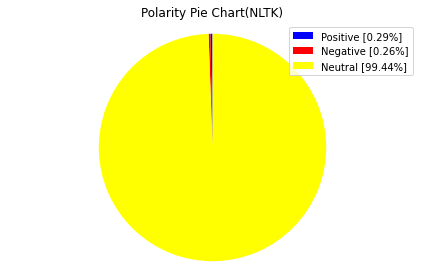

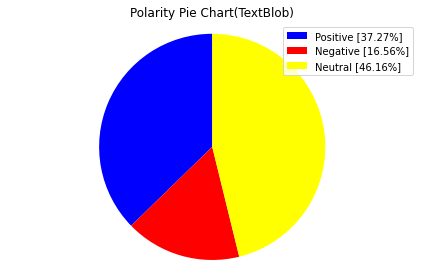

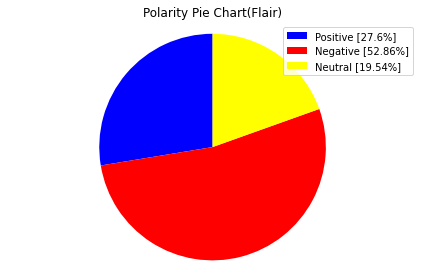

In [102]:

pos_nltk=0
neg_nltk=0
neu_nltk=0
for polarity in df['sentiment_nltk']:
  if polarity=="pos":
    pos_nltk+=1
  if polarity=="neg":
    neg_nltk+=1
  if polarity=="neu":
    neu_nltk+=1
nltk_positive = percentage(pos_nltk,(pos_nltk + neg_nltk + neu_nltk))
nltk_negative = percentage(neg_nltk,(pos_nltk + neg_nltk + neu_nltk))
nltk_neutral = percentage(neu_nltk,(pos_nltk + neg_nltk + neu_nltk))

nltk_positive = float(format(nltk_positive,'.2f'))
nltk_negative = float(format(nltk_negative,'.2f'))
nltk_neutral = float(format(nltk_neutral,'.2f'))

labels = ['Positive ['+str(nltk_positive)+'%]', 'Negative ['+str(nltk_negative)+'%]', 
'Neutral ['+str(nltk_neutral)+'%]']
sizes = [nltk_positive, nltk_negative, nltk_neutral]
colors = ['blue','red','yellow']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches,labels,loc="best")
plt.title("Polarity Pie Chart(NLTK)")
plt.axis('equal')
plt.tight_layout()
plt.show()
  
pos_blob=0
neg_blob=0
neu_blob=0
for polarity in df['sentiment_blob']:
  if polarity=="pos":
    pos_blob+=1
  if polarity=="neg":
    neg_blob+=1
  if polarity=="neu":
    neu_blob+=1
blob_positive = percentage(pos_blob,(pos_blob + neg_blob + neu_blob))
blob_negative = percentage(neg_blob,(pos_blob + neg_blob + neu_blob))
blob_neutral = percentage(neu_blob,(pos_blob + neg_blob + neu_blob))

blob_positive = float(format(blob_positive,'.2f'))
blob_negative = float(format(blob_negative,'.2f'))
blob_neutral = float(format(blob_neutral,'.2f'))

labels = ['Positive ['+str(blob_positive)+'%]', 'Negative ['+str(blob_negative)+'%]', 
'Neutral ['+str(blob_neutral)+'%]']
sizes = [blob_positive, blob_negative, blob_neutral]
colors = ['blue','red','yellow']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches,labels,loc="best")
plt.title("Polarity Pie Chart(TextBlob)")
plt.axis('equal')
plt.tight_layout()
plt.show()


pos_flair=0
neg_flair=0
neu_flair=0
for polarity in df['sentiment_flair']:
  if polarity=="pos":
    pos_flair+=1
  if polarity=="neg":
    neg_flair+=1
  if polarity=="neu":
    neu_flair+=1
flair_positive = percentage(pos_flair,(pos_flair + neg_flair + neu_flair))
flair_negative = percentage(neg_flair,(pos_flair + neg_flair + neu_flair))
flair_neutral = percentage(neu_flair,(pos_flair + neg_flair + neu_flair))

flair_positive = float(format(flair_positive,'.2f'))
flair_negative = float(format(flair_negative,'.2f'))
flair_neutral = float(format(flair_neutral,'.2f'))

labels = ['Positive ['+str(flair_positive)+'%]', 'Negative ['+str(flair_negative)+'%]', 
'Neutral ['+str(flair_neutral)+'%]']
sizes = [flair_positive, flair_negative, flair_neutral]
colors = ['blue','red','yellow']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches,labels,loc="best")
plt.title("Polarity Pie Chart(Flair)")
plt.axis('equal')
plt.tight_layout()
plt.show()

  

In [108]:
stopwords = ["OmicronVariant","omicronvirus","coronavirus","covid19", "case","covid","us", "will","cases", "new", 'variant', 'omicron','u','s','t'] + list(STOPWORDS)

texts_nltk_pos = " ".join(sentiment for sentiment in df[df['sentiment_nltk']=='pos']['text_clean'])
texts_blob_pos = " ".join(sentiment for sentiment in df[df['sentiment_blob']=='pos']['text_clean'])
texts_flair_pos = " ".join(sentiment for sentiment in df[df['sentiment_flair']=='pos']['text_clean'])

wordcloud_nltk_pos = WordCloud(width=800,
                      stopwords=stopwords,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='black').generate(texts_nltk_pos)

wordcloud_blob_pos = WordCloud(width=800,
                      stopwords=stopwords,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='black').generate(texts_blob_pos)

wordcloud_flair_pos = WordCloud(width=800,
                      stopwords=stopwords,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='black').generate(texts_flair_pos)





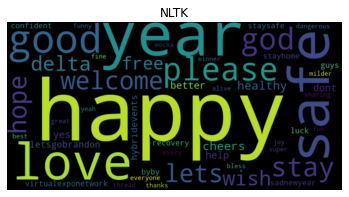

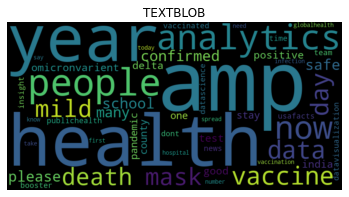

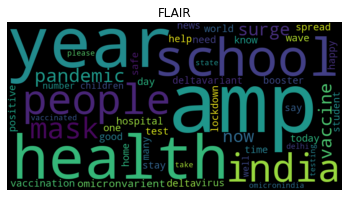

In [109]:
plt.imshow(wordcloud_nltk_pos, interpolation="bilinear")
plt.axis("off")
plt.title('NLTK')
plt.show()

plt.imshow(wordcloud_blob_pos, interpolation="bilinear")
plt.axis("off")
plt.title('TEXTBLOB')
plt.show()

plt.imshow(wordcloud_flair_pos, interpolation="bilinear")
plt.axis("off")
plt.title('FLAIR')
plt.show()


In [111]:

texts_nltk_neg = " ".join(sentiment for sentiment in df[df['sentiment_nltk']=='neg']['text_clean'])
texts_blob_neg = " ".join(sentiment for sentiment in df[df['sentiment_blob']=='neg']['text_clean'])
texts_flair_neg = " ".join(sentiment for sentiment in df[df['sentiment_flair']=='neg']['text_clean'])

In [112]:
wordcloud_nltk_neg = WordCloud(width=800,
                      stopwords=stopwords,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='black').generate(texts_nltk_neg)
wordcloud_blob_neg = WordCloud(width=800,
                      stopwords=stopwords,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='black').generate(texts_blob_neg)
wordcloud_flair_neg = WordCloud(width=800,
                      stopwords=stopwords,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='black').generate(texts_flair_neg)


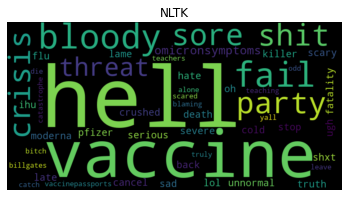

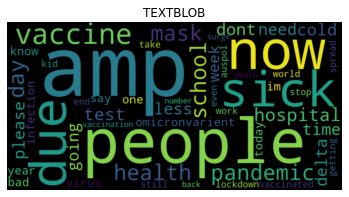

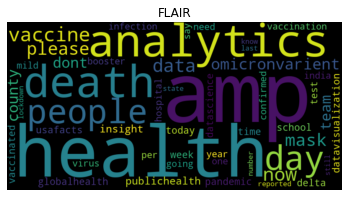

In [113]:
plt.imshow(wordcloud_nltk_neg, interpolation="bilinear")
plt.axis("off")
plt.title('NLTK')
plt.show()

plt.imshow(wordcloud_blob_neg, interpolation="bilinear")
plt.axis("off")
plt.title('TEXTBLOB')
plt.show()


plt.imshow(wordcloud_flair_neg, interpolation="bilinear")
plt.axis("off")
plt.title('FLAIR')
plt.show()

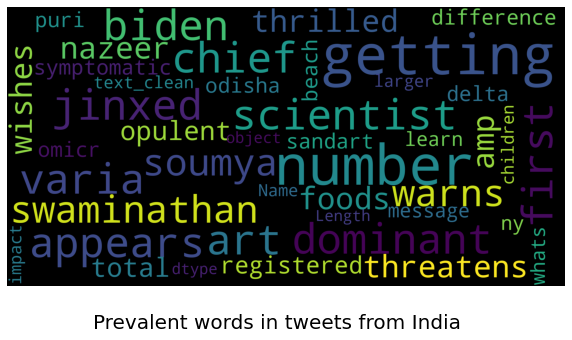

In [52]:
india_df = df.loc[df.location=="India"]
show_wordcloud(india_df['text_clean'], title = 'Prevalent words in tweets from India')

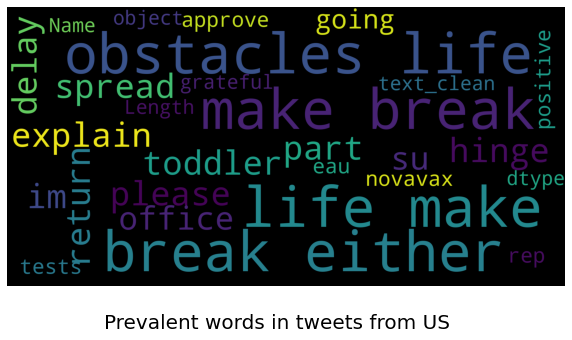

In [54]:
us_df = df.loc[df.location=="United States"]
show_wordcloud(us_df['text_clean'], title = 'Prevalent words in tweets from US')

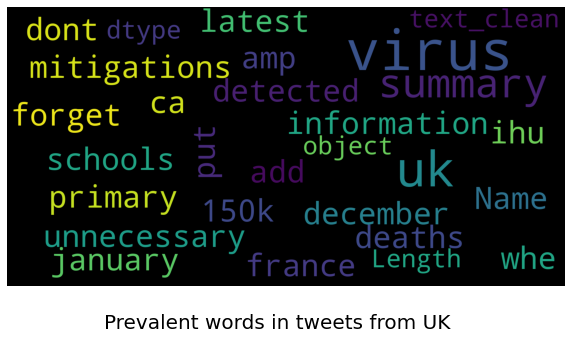

In [56]:
us_df = df.loc[df.location=="United Kingdom"]
show_wordcloud(us_df['text_clean'], title = 'Prevalent words in tweets from UK')

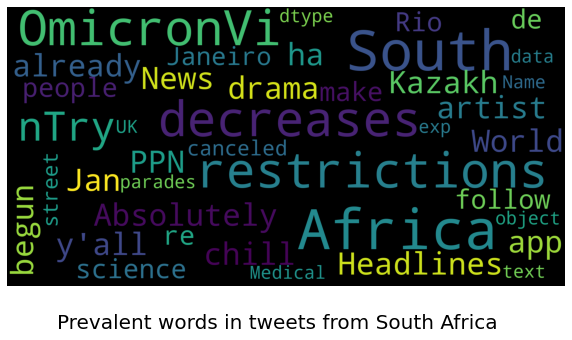

In [57]:
sa_df = df.loc[df.location=="South Africa"]
show_wordcloud(sa_df['text'], title = 'Prevalent words in tweets from South Africa')

In [114]:
india=df.loc[df.country=="India"]
in_values=india['sentiment_blob'].value_counts()
in_pos_perc=(in_values.pos/in_values.sum())*100
print(in_pos_perc)
in_neg_perc=(in_values.neg/in_values.sum())*100
print(in_neg_perc)

31.98482932996207
46.43910661609777


In [115]:
usa=df.loc[df.location=="USA"]
usa_values=usa['sentiment_blob'].value_counts()
usa_pos_perc=(usa_values.pos/usa_values.sum())*100
print(usa_pos_perc)
usa_neg_perc=(usa_values.neg/usa_values.sum())*100
print(usa_neg_perc)

20.238095238095237
64.28571428571429


In [116]:
uk=df.loc[df.country=="United Kingdom"]
uk_values=uk['sentiment_blob'].value_counts()
uk_pos_perc=(uk_values.pos/uk_values.sum())*100
print(uk_pos_perc)
uk_neg_perc=(uk_values.neg/uk_values.sum())*100
print(uk_neg_perc)

31.93717277486911
59.16230366492147


In [117]:
sa=df.loc[df.country=="South Africa"]
sa_values=sa['sentiment_blob'].value_counts()
sa_pos_perc=(sa_values.pos/sa_values.sum())*100
print(sa_pos_perc)
sa_neg_perc=(sa_values.neg/sa_values.sum())*100
print(sa_neg_perc)

16.27906976744186
67.44186046511628


In [118]:
aus=df.loc[df.country=="Australia"]
aus_values=aus['sentiment_blob'].value_counts()
aus_pos_perc=(aus_values.pos/aus_values.sum())*100
print(aus_pos_perc)
aus_neg_perc=(aus_values.neg/aus_values.sum())*100
print(aus_neg_perc)

21.22641509433962
59.905660377358494


In [119]:
chn=df.loc[df.country=="Canada"]
chn_values=chn['sentiment_blob'].value_counts()
chn_pos_perc=(chn_values.pos/chn_values.sum())*100
print(chn_pos_perc)
chn_neg_perc=(chn_values.neg/chn_values.sum())*100
print(chn_neg_perc)

28.47222222222222
50.34722222222222


In [120]:
fr=df.loc[df.country=="France"]
fr_values=fr['sentiment_blob'].value_counts()
fr_pos_perc=(fr_values.pos/fr_values.sum())*100
print(fr_pos_perc)
fr_neg_perc=(fr_values.neg/fr_values.sum())*100
print(fr_neg_perc)

20.0
60.0


In [121]:
pk=df.loc[df.location=="Pakistan"]
pk_values=pk['sentiment_blob'].value_counts()
pk_pos_perc=(pk_values.pos/pk_values.sum())*100
print(pk_pos_perc)
pk_neg_perc=(pk_values.neg/pk_values.sum())*100
print(pk_neg_perc)

30.76923076923077
28.205128205128204


In [122]:
gr=df.loc[df.country=="Germany"]
gr_values=gr['sentiment_blob'].value_counts()
gr_pos_perc=(gr_values.pos/gr_values.sum())*100
print(gr_pos_perc)
gr_neg_perc=(gr_values.neg/gr_values.sum())*100
print(gr_neg_perc)

39.58333333333333
52.083333333333336


In [123]:
sp=df.loc[df.country=="Italy"]
sp_values=sp['sentiment_blob'].value_counts()
sp_pos_perc=(sp_values.pos/sp_values.sum())*100
print(sp_pos_perc)
sp_neg_perc=(sp_values.neg/sp_values.sum())*100
print(sp_neg_perc)


18.181818181818183
81.81818181818183


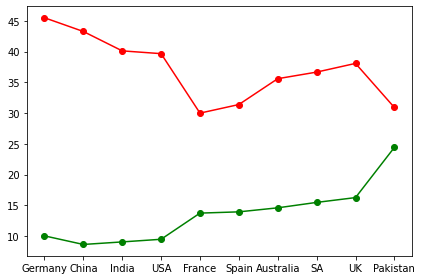

In [ ]:
x = ('Germany','China','India','USA','France','Spain','Australia','SA','UK','Pakistan')
y = [45.5026455026455,43.269230769230774,40.11828486939379,39.66480446927375,30.0,31.3953488372093,35.59670781893004,36.666666666666664, 38.079096045197744,30.916030534351147]
z = [10.052910052910052,8.653846153846153,9.068506653523903,9.497206703910614,13.750000000000002,13.953488372093023, 14.609053497942387,15.490196078431373,16.271186440677965,24.427480916030532,]
x_pos = np.arange(len(x))
plt.rcParams["figure.autolayout"] = True
plt.plot(x_pos, y, '-ok',color='red')
plt.plot(x_pos, z, '-ok',color='green')
plt.xticks(x_pos, x)
plt.show()

In [81]:
pip install NRCLex

     |████████████████████████████████| 396 kB 28.4 MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43328 sha256=1f360c13093ad162be2acad8a770d16796300f5bd97067861819c3c25be6d285
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built NRCLex


In [84]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [85]:
from nrclex import NRCLex
str_tweet = ",".join(df["text"])
text_object = NRCLex(str_tweet)

In [86]:
data = text_object.raw_emotion_scores

In [87]:
data

{'anger': 4745,
 'anticipation': 7234,
 'disgust': 3811,
 'fear': 9476,
 'joy': 4195,
 'negative': 13979,
 'positive': 14453,
 'sadness': 6969,
 'surprise': 3697,
 'trust': 8771}

In [91]:
emotion_df = pd.DataFrame.from_dict(data, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)
import plotly.express as px
fig = px.bar(emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

In [92]:
perc_data=text_object.affect_frequencies

In [94]:
perc_emotion_df = pd.DataFrame.from_dict(perc_data, orient='index')
perc_emotion_df = perc_emotion_df.reset_index()
perc_emotion_df = perc_emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
perc_emotion_df = perc_emotion_df.sort_values(by=['Emotion Count'], ascending=False)
import plotly.express as px
fig = px.bar(perc_emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

{'anger': 0.061360403465666624,
 'anticip': 0.0,
 'anticipation': 0.0935471356523988,
 'disgust': 0.049282296650717705,
 'fear': 0.1225397646450278,
 'joy': 0.05424802793223846,
 'negative': 0.18077072287598603,
 'positive': 0.1869002974266132,
 'sadness': 0.09012026380447433,
 'surprise': 0.04780809517651623,
 'trust': 0.1134229923703608}